# 数据处理

In [ ]:
import matplotlib.pyplot as plt
from pandas import DataFrame, concat
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dropout, Attention, MultiHeadAttention, Flatten
from tensorflow.keras.layers import Dropout, Dense, LSTM, Bidirectional, Attention, SimpleRNN, GRU
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import optuna
import numpy as np
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pylab import mpl
from datetime import datetime, timedelta

import math
import os
import time
import gc
import pathlib

# to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

# display all columns of the dataframe
pd.options.display.max_columns = None

# display all rows of the dataframe
pd.options.display.max_rows = None

# to display the float values upto 6 decimal places
pd.options.display.float_format = '{:.6f}'.format


plt.rcParams['figure.figsize'] = (10, 7)


import seaborn as sns
sns.set_style('whitegrid')
# plt.style.use("fivethirtyeight")
%matplotlib inline

# 设置中文显示字体
mpl.rcParams["font.sans-serif"] = ["Arial"]


# 将时间序列数据转化为可监督数据

In [29]:
def fillna_mean(df):
    for cols in list(df.columns[df.isnull().sum() > 0]):
        mean_val = df[cols].mean()  # 均值填充
        df[cols].fillna(mean_val, inplace=True)
    return df


def fillna_back(df):
    df = df.fillna(axis=0, method="bfill", limit=None)  #后一个数填充缺失值
    return df

In [30]:
# prepare data for lstm
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
     Frame a time series as a supervised learning dataset.
     Arguments:
     data: Sequence of observations as a list or NumPy array.
     n_in: Number of lag observations as input (X).
     n_out: Number of observations as output (y).
     dropnan: Boolean whether or not to drop rows with NaN values.
     Returns:
     Pandas DataFrame of series framed for supervised learning.
     """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 数据标准化

In [31]:
from pathlib import Path

# Đọc tất cả các file CSV trong thư mục data của dự án
data_dir = Path('data')
csv_files = sorted(data_dir.glob('*.csv'))

if not csv_files:
    raise FileNotFoundError('Không tìm thấy file CSV trong thư mục data')

dfs = []
for path in csv_files:
    print('File path : ', path)
    dfs.append(pd.read_csv(path, encoding='utf-8'))

df_AQI = pd.concat(dfs, ignore_index=True)

dataset = fillna_back(df_AQI)
dataset = dataset.drop(['No','year','month','day','hour','wd','station'], axis=1)


File path :  data/PRSA_Data_Aotizhongxin_20130301-20170228.csv
File path :  data/PRSA_Data_Changping_20130301-20170228.csv
File path :  data/PRSA_Data_Dingling_20130301-20170228.csv
File path :  data/PRSA_Data_Dongsi_20130301-20170228.csv
File path :  data/PRSA_Data_Guanyuan_20130301-20170228.csv
File path :  data/PRSA_Data_Gucheng_20130301-20170228.csv
File path :  data/PRSA_Data_Huairou_20130301-20170228.csv
File path :  data/PRSA_Data_Nongzhanguan_20130301-20170228.csv
File path :  data/PRSA_Data_Shunyi_20130301-20170228.csv
File path :  data/PRSA_Data_Tiantan_20130301-20170228.csv
File path :  data/PRSA_Data_Wanliu_20130301-20170228.csv
File path :  data/PRSA_Data_Wanshouxigong_20130301-20170228.csv


# IQR处理异常值

In [32]:
#Remove outliers from the data set 
#not standard approach
print('Before: Outliers Treating with IQR', dataset.shape)
df_outlier = dataset.copy()
# df_outlier.drop(['PM10'], axis=1, inplace=True)
df_outlier  = df_outlier.select_dtypes(exclude ='object')
#1st quantile
q1 = df_outlier.quantile(0.25)

#3rd quantile
q3 = df_outlier.quantile(0.75)

# IQR: The Interquartile Range is defined as the difference between the third and first quartile
# calculate IQR for each numeric variable
iqr = q3-q1
# print(IQR)
# retrieve the dataframe without the outliers
# '~' returns the values that do not satisfy the given conditions 
# i.e. it returns values between the range [Q1-1.5*IQR, Q3+1.5*IQR]
# '|' is used as 'OR' operator on multiple conditions   
# 'any(axis=1)' checks the entire row for atleast one 'True' entry (those rows represents outliers in the data)
df_outlier = df_outlier[~((df_outlier  < (q1-(1.5*iqr))) | (df_outlier  > (q3+(1.5*iqr)))).any(axis=1)]

# check the shape of the data
print('After: Outliers Treating with IQR', df_outlier.shape)

Before: Outliers Treating with IQR (420768, 11)
After: Outliers Treating with IQR (305957, 11)


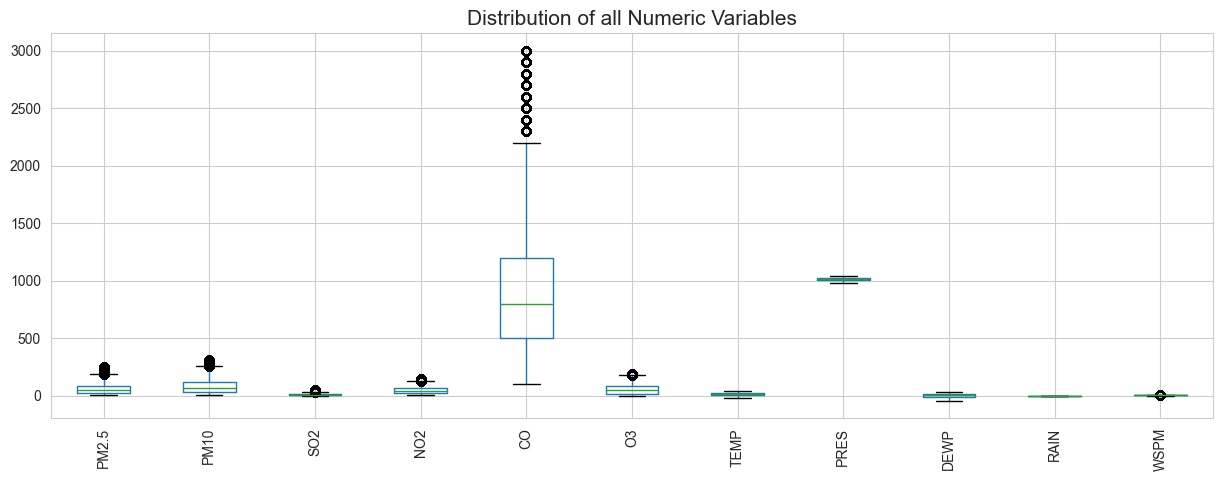

In [33]:
df_outlier = df_outlier.select_dtypes(exclude='object').copy()
# df_outlier.drop('PM10', inplace=True, axis=1)
# set the plot size using figure()
# pass width and height in inches to 'figsize' 
plt.figure(figsize = (15,5))

# plot a boxplot to visualize the outliers in all the numeric variables
df_outlier.boxplot()

# set plot label
# set text size using 'fontsize'
plt.title('Distribution of all Numeric Variables', fontsize = 15)

# xticks() returns the x-axis ticks
# 'rotation = vertical' rotates the x-axis labels vertically
plt.xticks(rotation = 'vertical', fontsize = 10)

# display the plot
plt.show()

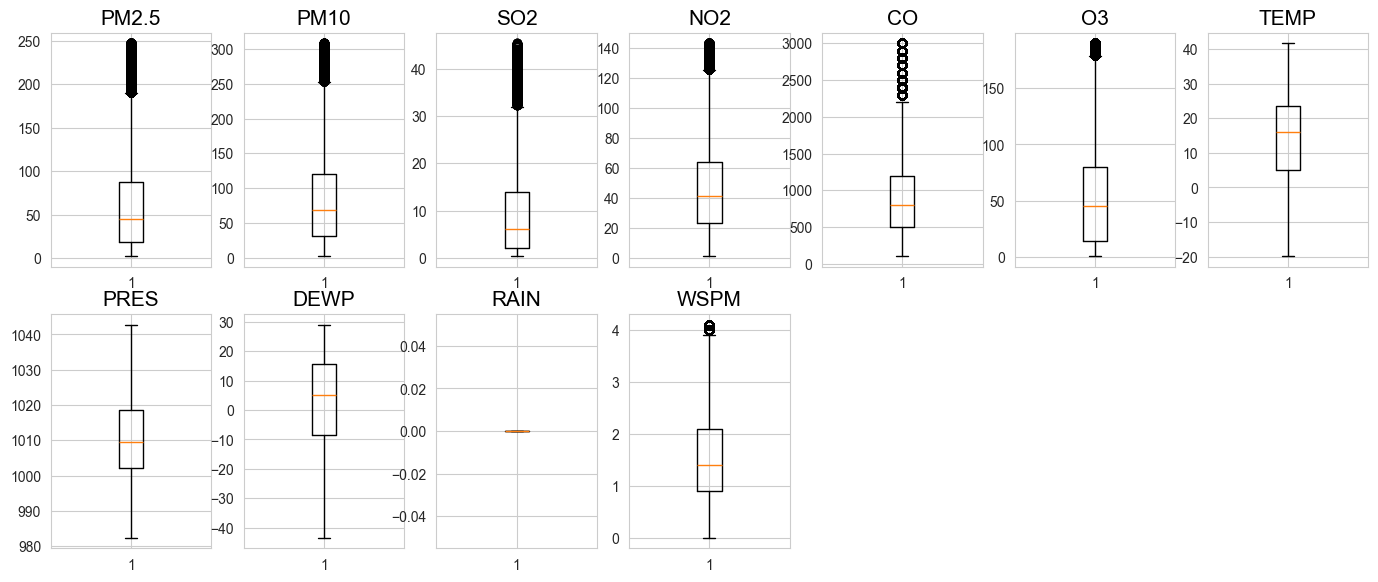

In [34]:
# df_comp = df_comp.select_dtypes(exclude='object').copy()
plt.rcParams['figure.dpi'] = 100
df_out=df_outlier.copy()
outliers_by_variables = df_out.columns

plt.figure(figsize=(17,14))
for i in range(0,outliers_by_variables.shape[0]):
    plt.subplot(4,7, i+1)
    plt.boxplot(df_out[outliers_by_variables[i]], autorange=True)
    plt.title(outliers_by_variables[i], fontdict= {'fontsize': 15 ,'fontweight': 5, 'color':'000000'})
    plt.AutoLocator.default_params

In [35]:
values = df_outlier.values
values = values.astype('float32')
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 3, 1)

In [9]:
# df_out.head()
# pm2=df_out.pop('PM2.5')
# values=pm2.values
# values = values.astype('float32')
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(values)
# # frame as supervised learning
# reframed = series_to_supervised(scaled, 7, 1)

# 划分数据集

In [36]:
# split into train sets、validation sets and test sets
values = reframed.values
number=len(values)
n_train_hours = int(number*0.7)
n_valid_hours = int(number*0.9)
train = values[:n_train_hours, :]
valid = values[n_train_hours:n_valid_hours, :]
test = values[n_valid_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-11], train[:, -11:-5]
valid_X, valid_y = valid[:, :-11], valid[:, -11:-5]
test_X, test_y = test[:, :-11], test[:, -11:-5]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape,
      test_y.shape)  # [samples, timesteps, features]

(214167, 1, 33) (214167, 6) (61191, 1, 33) (61191, 6) (30596, 1, 33) (30596, 6)


# 定义和拟合模型

In [37]:
titles = [
    "PM2.5",
    "PM10",
    "SO2",
    "NO2",
    "CO",
    "O3",
     "TEM",
    "PRES",
    "DEMP",
    "RAIN",
    "WSPM",
]

feature_keys = [
    "PM2.5",
    "PM10",
    "SO2",
    "NO2",
    "CO",
    "O3",
     "TEM",
    "PRES",
    "DEMP",
    "RAIN",
    "WSPM",

]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "brown",
    "cyan",
    "gray",
    "olive",
    "purple",
    "pink",
    "gold",

]


In [42]:
def visualize_loss(history, title):
    # Visualize training and validation loss
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    
    plt.figure(dpi=300)
    plt.plot(epochs, loss, "green", label="Training Loss")
    plt.plot(epochs, val_loss, color="purple", label="Validation Loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def visualize_acc(history, title):
    # Visualize training and validation MAE (metric for regression)
    mae = history.history["mae"]
    val_mae = history.history["val_mae"]
    epochs = range(len(mae))
    
    plt.figure(dpi=300)
    plt.plot(epochs, mae, "b", label="Training MAE")
    plt.plot(epochs, val_mae, "r", label="Validation MAE")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.show()


In [43]:
def compare_visual(data1, data2):
    fig, axes = plt.subplots(
        nrows=2, ncols=3, figsize=(20, 15), dpi=300, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)-5):
        key = feature_keys[i]
        ax = data1[key].plot(
            ax=axes[i // 3, i % 3],
            title="{}".format(titles[i]),
            rot=25,
            label="actual"
        )
        ax = data2[key].plot(
            ax=axes[i // 3, i % 3],
            color='red',
            rot=25,
            label='prediction'
        )
        ax.legend()
    plt.tight_layout()

    # scaler.inverse_transform()


def inv_scale(df, y):
    max = df.max()[-11:-5]
    min = df.min()[-11:-5]
#     df*(max-min)+min
    yy=y.copy()
    for i in range(len(yy)):
        yy[i] = yy[i]*(max-min)+min  
    return yy


def evaluate(model):
    # make a prediction
    yhat = model.predict(test_X)
    # move return_sequences=True
#     inv_yhat = scaler.inverse_transform(yhat)
    # invert scaling for actual
#     inv_y = scaler.inverse_transform(test_y)
    inv_yhat=inv_scale(dataset,yhat)
    inv_y=inv_scale(dataset,test_y)

    # calculate RMSE均方差
#     aqi_inv_y = inv_y[:, -6:]
#     aqi_inv_yhat = inv_yhat[:, -6:]
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    mae = mean_absolute_error(inv_y, inv_yhat)
    print('Test MAE: %.3f' % mae)
    R2=r2_score(inv_y, inv_yhat)
    print('Test R2: %.3f' % R2)
    # 可视化真实值和预测值
    y1 = DataFrame(
        inv_y[-100:], index=dataset.index[-100:], columns=dataset.columns[-11:-5])
    y2 = DataFrame(
        inv_yhat[-100:], index=dataset.index[-100:], columns=dataset.columns[-11:-5])
    compare_visual(y1,y2)

In [49]:
epochs = 50
batch_size = 32
learning_rate = 0.001

timesteps = train_X.shape[1]
input_dim = train_X.shape[2]
output_dim=6

# RNN

Epoch 1/50
6693/6693 ━━━━━━━━━━━━━━━━━━━━ 117s 17ms/step - loss: 0.0086 - mae: 0.0618 - val_loss: 0.0107 - val_mae: 0.0740
Epoch 2/50
6693/6693 ━━━━━━━━━━━━━━━━━━━━ 104s 15ms/step - loss: 0.0097 - mae: 0.0688 - val_loss: 0.0148 - val_mae: 0.0885
Epoch 3/50
6693/6693 ━━━━━━━━━━━━━━━━━━━━ 104s 16ms/step - loss: 0.0108 - mae: 0.0742 - val_loss: 0.0099 - val_mae: 0.0701
Epoch 4/50
6693/6693 ━━━━━━━━━━━━━━━━━━━━ 105s 16ms/step - loss: 0.0116 - mae: 0.0775 - val_loss: 0.0116 - val_mae: 0.0770
Epoch 5/50
6693/6693 ━━━━━━━━━━━━━━━━━━━━ 108s 16ms/step - loss: 0.0124 - mae: 0.0805 - val_loss: 0.0103 - val_mae: 0.0724
Epoch 6/50
6693/6693 ━━━━━━━━━━━━━━━━━━━━ 116s 17ms/step - loss: 0.0134 - mae: 0.0839 - val_loss: 0.0125 - val_mae: 0.0806
Epoch 7/50
6693/6693 ━━━━━━━━━━━━━━━━━━━━ 102s 15ms/step - loss: 0.0138 - mae: 0.0854 - val_loss: 0.0223 - val_mae: 0.1122
Epoch 8/50
6693/6693 ━━━━━━━━━━━━━━━━━━━━ 111s 17ms/step - loss: 0.0150 - mae: 0.0888 - val_loss: 0.0180 - val_mae: 0.0959
Epoch 9/50
6693/

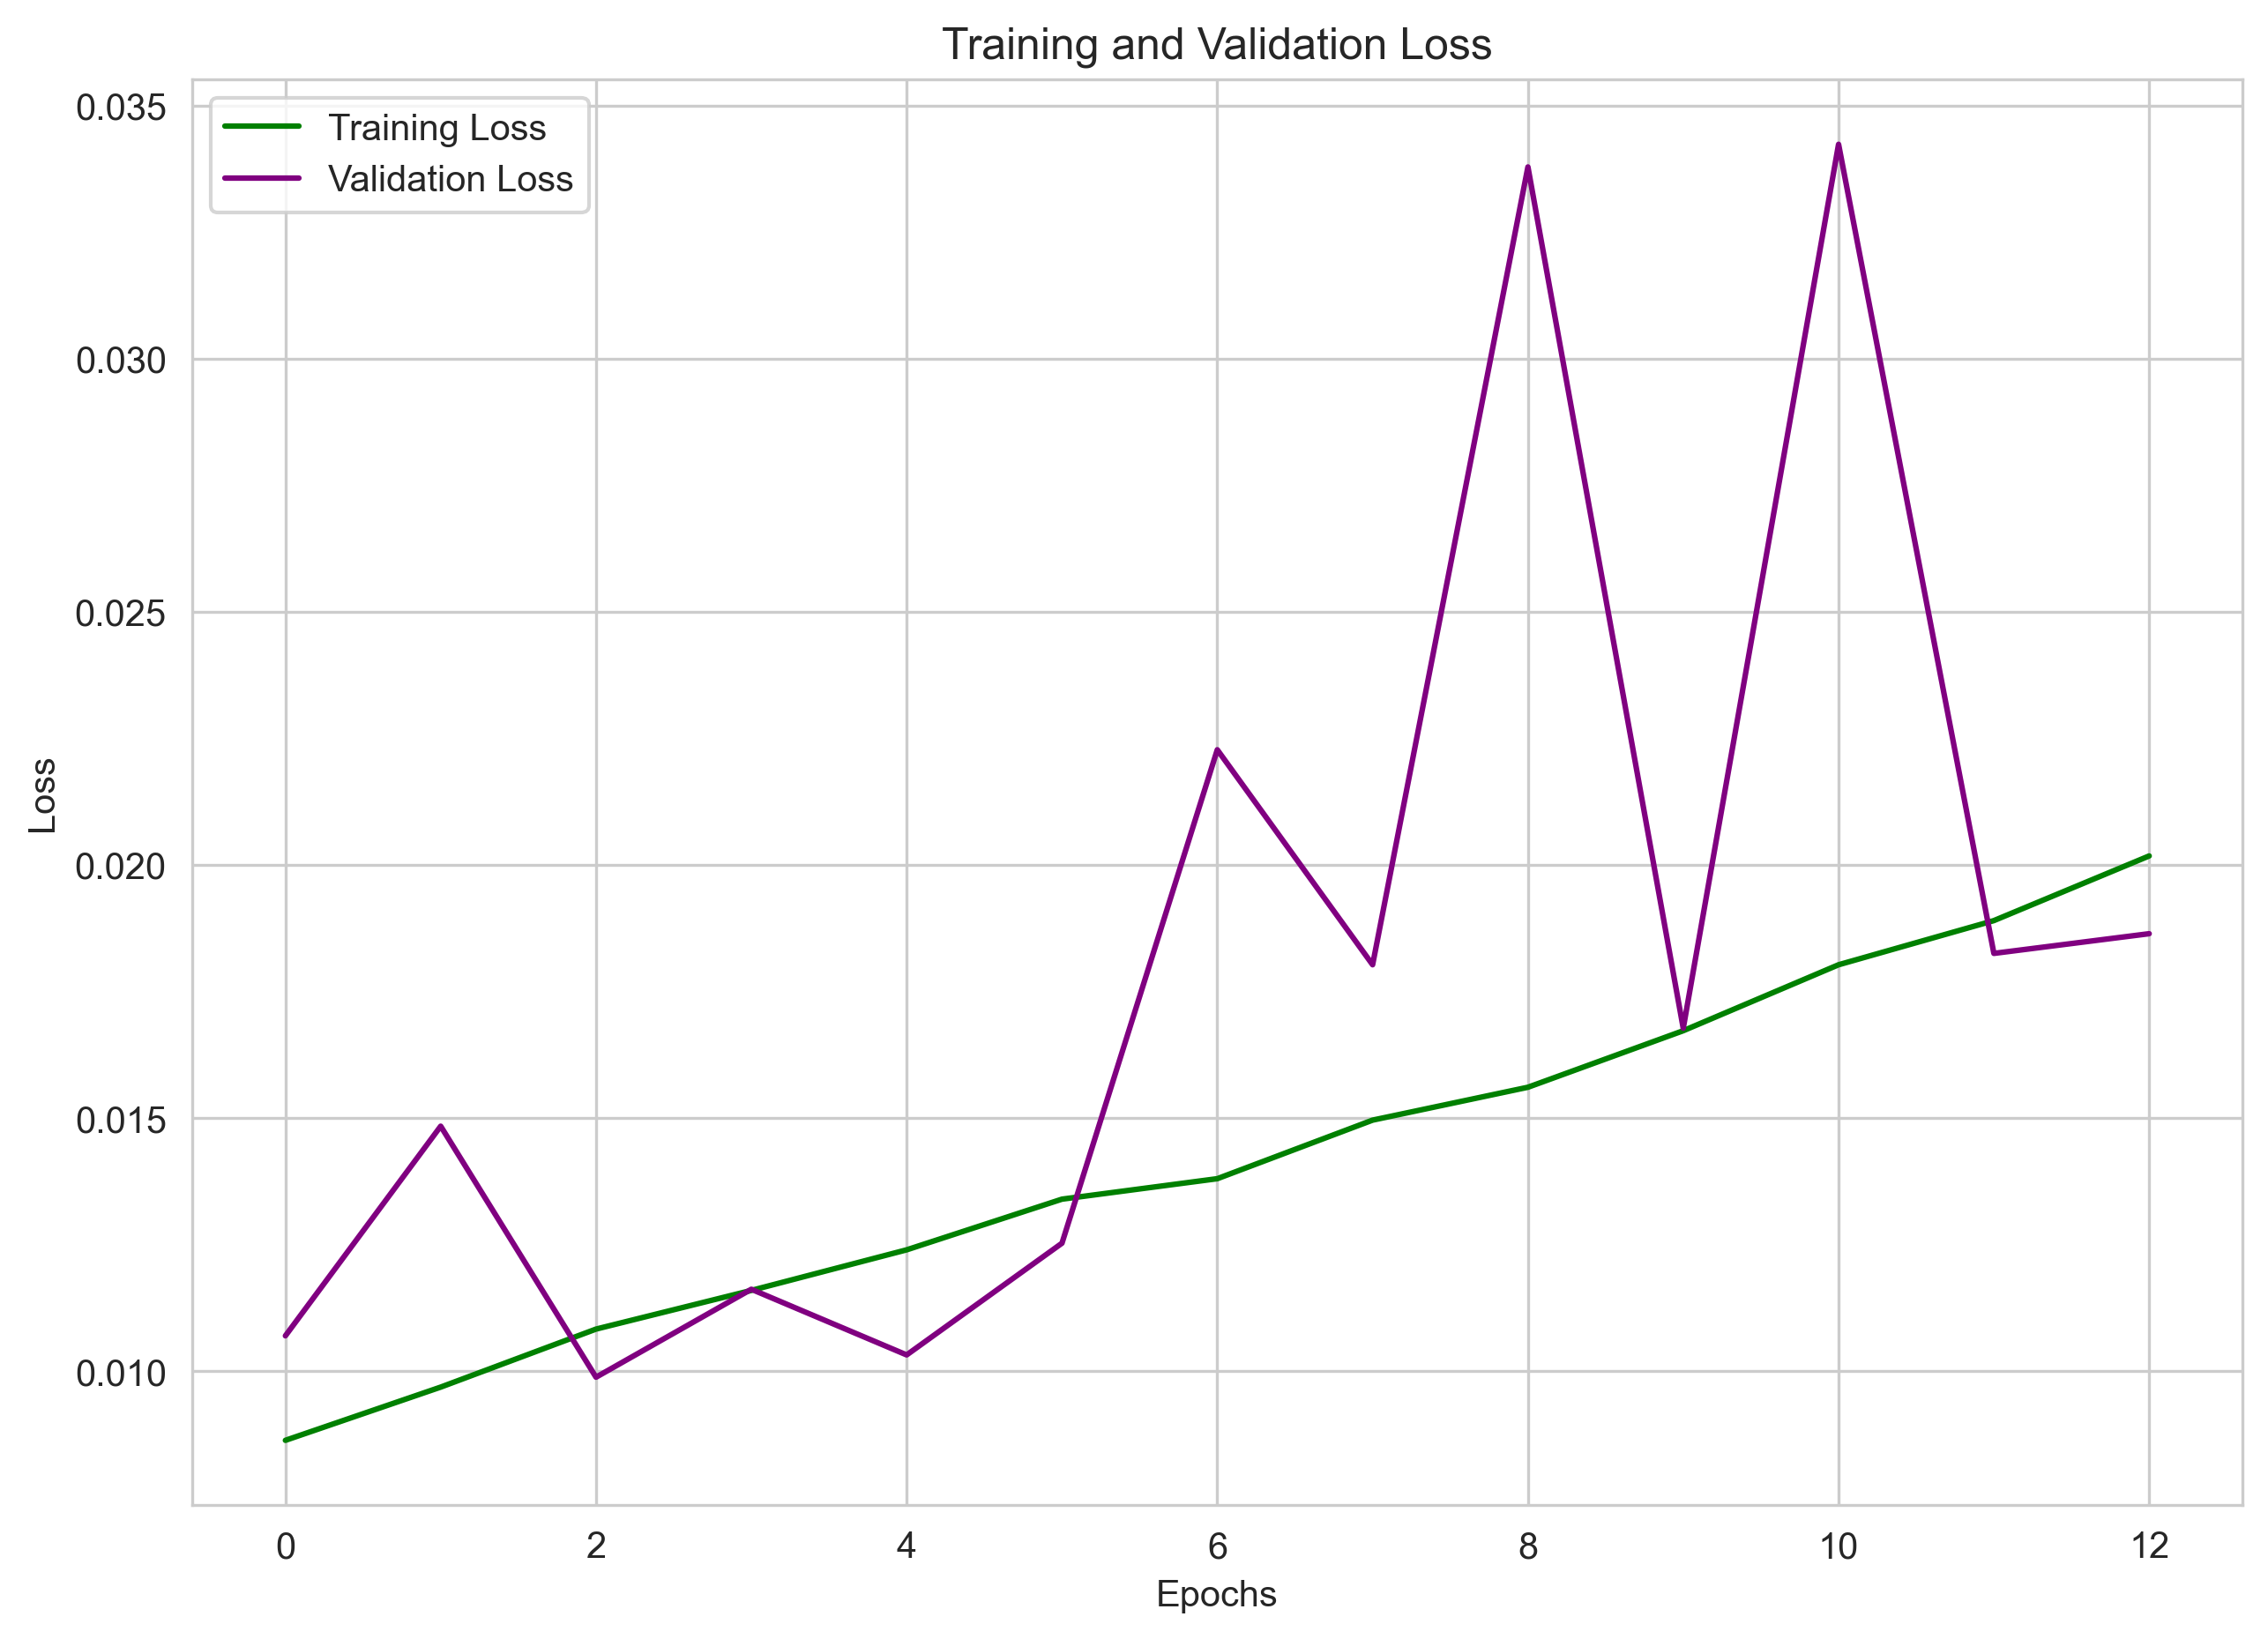

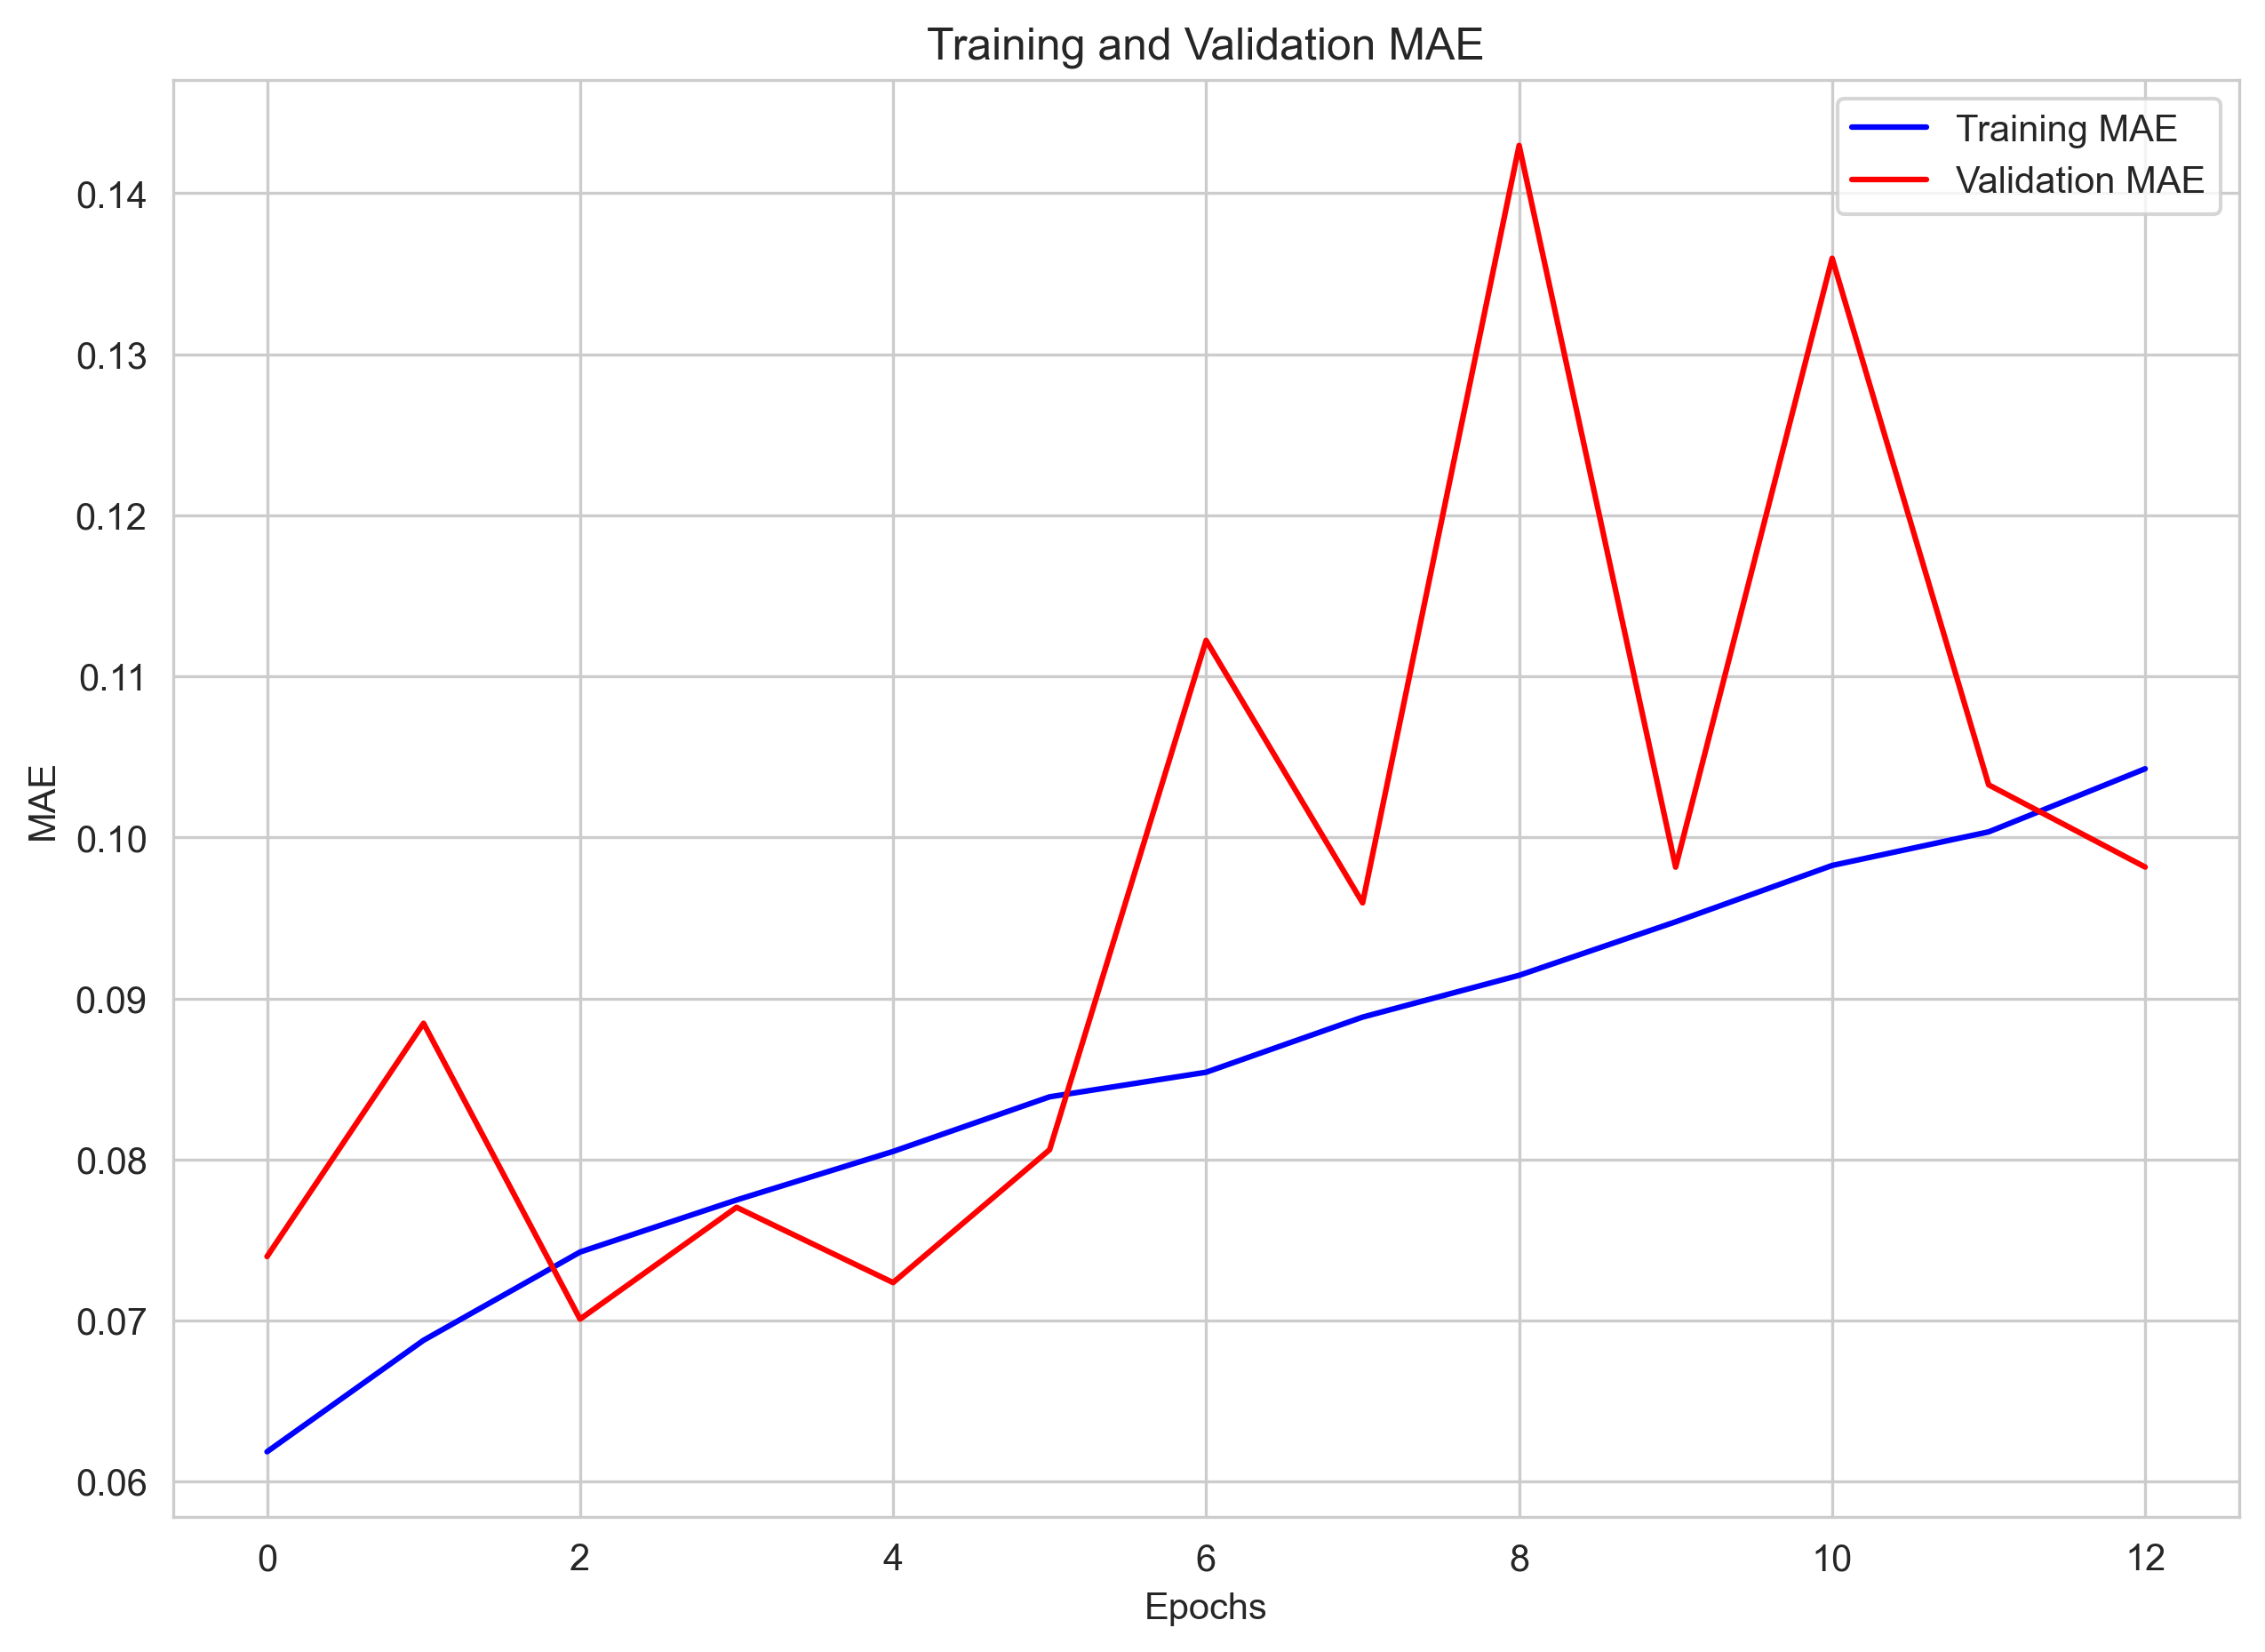

In [ ]:
# Define model input
inputs = Input(shape=(timesteps, input_dim))

# RNN layer (correct activation to prevent exploding gradient)
rnn_out = SimpleRNN(
    128,
    activation='tanh',          # FIXED (relu causes exploding gradients)
    return_sequences=False
)(inputs)

# Fully connected layer
dense = Dense(128, activation='relu')(rnn_out)

# Output layer for regression (no activation)
output = Dense(output_dim)(dense)

# Build model
rnn = Model(inputs=inputs, outputs=output)

# Compile model (accuracy removed because this is regression)
rnn.compile(
    loss='mse',
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['mae']  # FIXED
)

# Checkpoint path
path_checkpoint = "model_checkpoint_MultiAttLSTM_aqiPre.weights.h5"

es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=20,
    restore_best_weights=True
)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=0,
    save_weights_only=True,
    save_best_only=True
)

# Fit model with callbacks enabled
history = rnn.fit(
    train_X,
    train_y,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(valid_X, valid_y),
    callbacks=[es_callback, modelckpt_callback]
)

# Visualize
visualize_loss(history, "Training and Validation Loss")
visualize_acc(history, "Training and Validation MAE")


# GRU

In [52]:
# Define the model inputs, including the time-series data and labels
inputs = Input(shape=(timesteps, input_dim))

# Define the GRU layer and multi-head attention layer
gru_out = GRU(128, activation='relu', return_sequences=False)(inputs)

# Define the fully connected layer and output layer
dense = Dense(units=128, activation='relu')(gru_out)

output = Dense(units=output_dim, activation='relu')(dense)

# Define and compile the model
gru = Model(inputs=inputs, outputs=output)


gru.compile(loss='mse', optimizer=keras.optimizers.Adam(
    learning_rate=learning_rate), metrics=['accuracy'])

# plot_model(model, to_file="Bi-LSTM-MultiheadAtt.png",
#            dpi=300, show_shapes=True)

path_checkpoint = "model_checkpoint_MultiAttLSTM_aqiPre.weights.h5"
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0,
    patience=10
)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=0,
    save_weights_only=True,
    save_best_only=True,
)

# fit network
history = gru.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(valid_X, valid_y),
#                     callbacks=[es_callback, modelckpt_callback]
                    )
visualize_loss(history, "Training and Validation Loss")
visualize_acc(history, "Training and Validation Accuracy")

# evaluate(model)

Epoch 1/50
6693/6693 ━━━━━━━━━━━━━━━━━━━━ 138s 20ms/step - accuracy: 0.7901 - loss: 0.0074 - val_accuracy: 0.7821 - val_loss: 0.0085
Epoch 2/50
6693/6693 ━━━━━━━━━━━━━━━━━━━━ 135s 20ms/step - accuracy: 0.7908 - loss: 0.0075 - val_accuracy: 0.7748 - val_loss: 0.0080
Epoch 3/50
6693/6693 ━━━━━━━━━━━━━━━━━━━━ 140s 21ms/step - accuracy: 0.7566 - loss: 0.0107 - val_accuracy: 0.7666 - val_loss: 0.0137
Epoch 4/50
6693/6693 ━━━━━━━━━━━━━━━━━━━━ 137s 20ms/step - accuracy: 0.6251 - loss: 2.4327 - val_accuracy: 0.3428 - val_loss: 12.2037
Epoch 5/50
6693/6693 ━━━━━━━━━━━━━━━━━━━━ 132s 20ms/step - accuracy: 0.2820 - loss: 12.2350 - val_accuracy: 0.3428 - val_loss: 12.2037
Epoch 6/50
5941/6693 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.2847 - loss: 12.2478

KeyboardInterrupt: 

# LSTM 

Epoch 1/100
6693/6693 [==============================] - 46s 6ms/step - loss: 0.0076 - accuracy: 0.7913 - val_loss: 0.0064 - val_accuracy: 0.8035
Epoch 2/100
6693/6693 [==============================] - 43s 6ms/step - loss: 0.0068 - accuracy: 0.8026 - val_loss: 0.0060 - val_accuracy: 0.8106
Epoch 3/100
6693/6693 [==============================] - 52s 8ms/step - loss: 0.0067 - accuracy: 0.8045 - val_loss: 0.0061 - val_accuracy: 0.8096
Epoch 4/100
6693/6693 [==============================] - 43s 6ms/step - loss: 0.0066 - accuracy: 0.8058 - val_loss: 0.0063 - val_accuracy: 0.7979
Epoch 5/100
6693/6693 [==============================] - 42s 6ms/step - loss: 0.0066 - accuracy: 0.8067 - val_loss: 0.0060 - val_accuracy: 0.8080
Epoch 6/100
6693/6693 [==============================] - 52s 8ms/step - loss: 0.0065 - accuracy: 0.8074 - val_loss: 0.0061 - val_accuracy: 0.8056
Epoch 7/100
6693/6693 [==============================] - 42s 6ms/step - loss: 0.0065 - accuracy: 0.8083 - val_loss: 0.0062 -

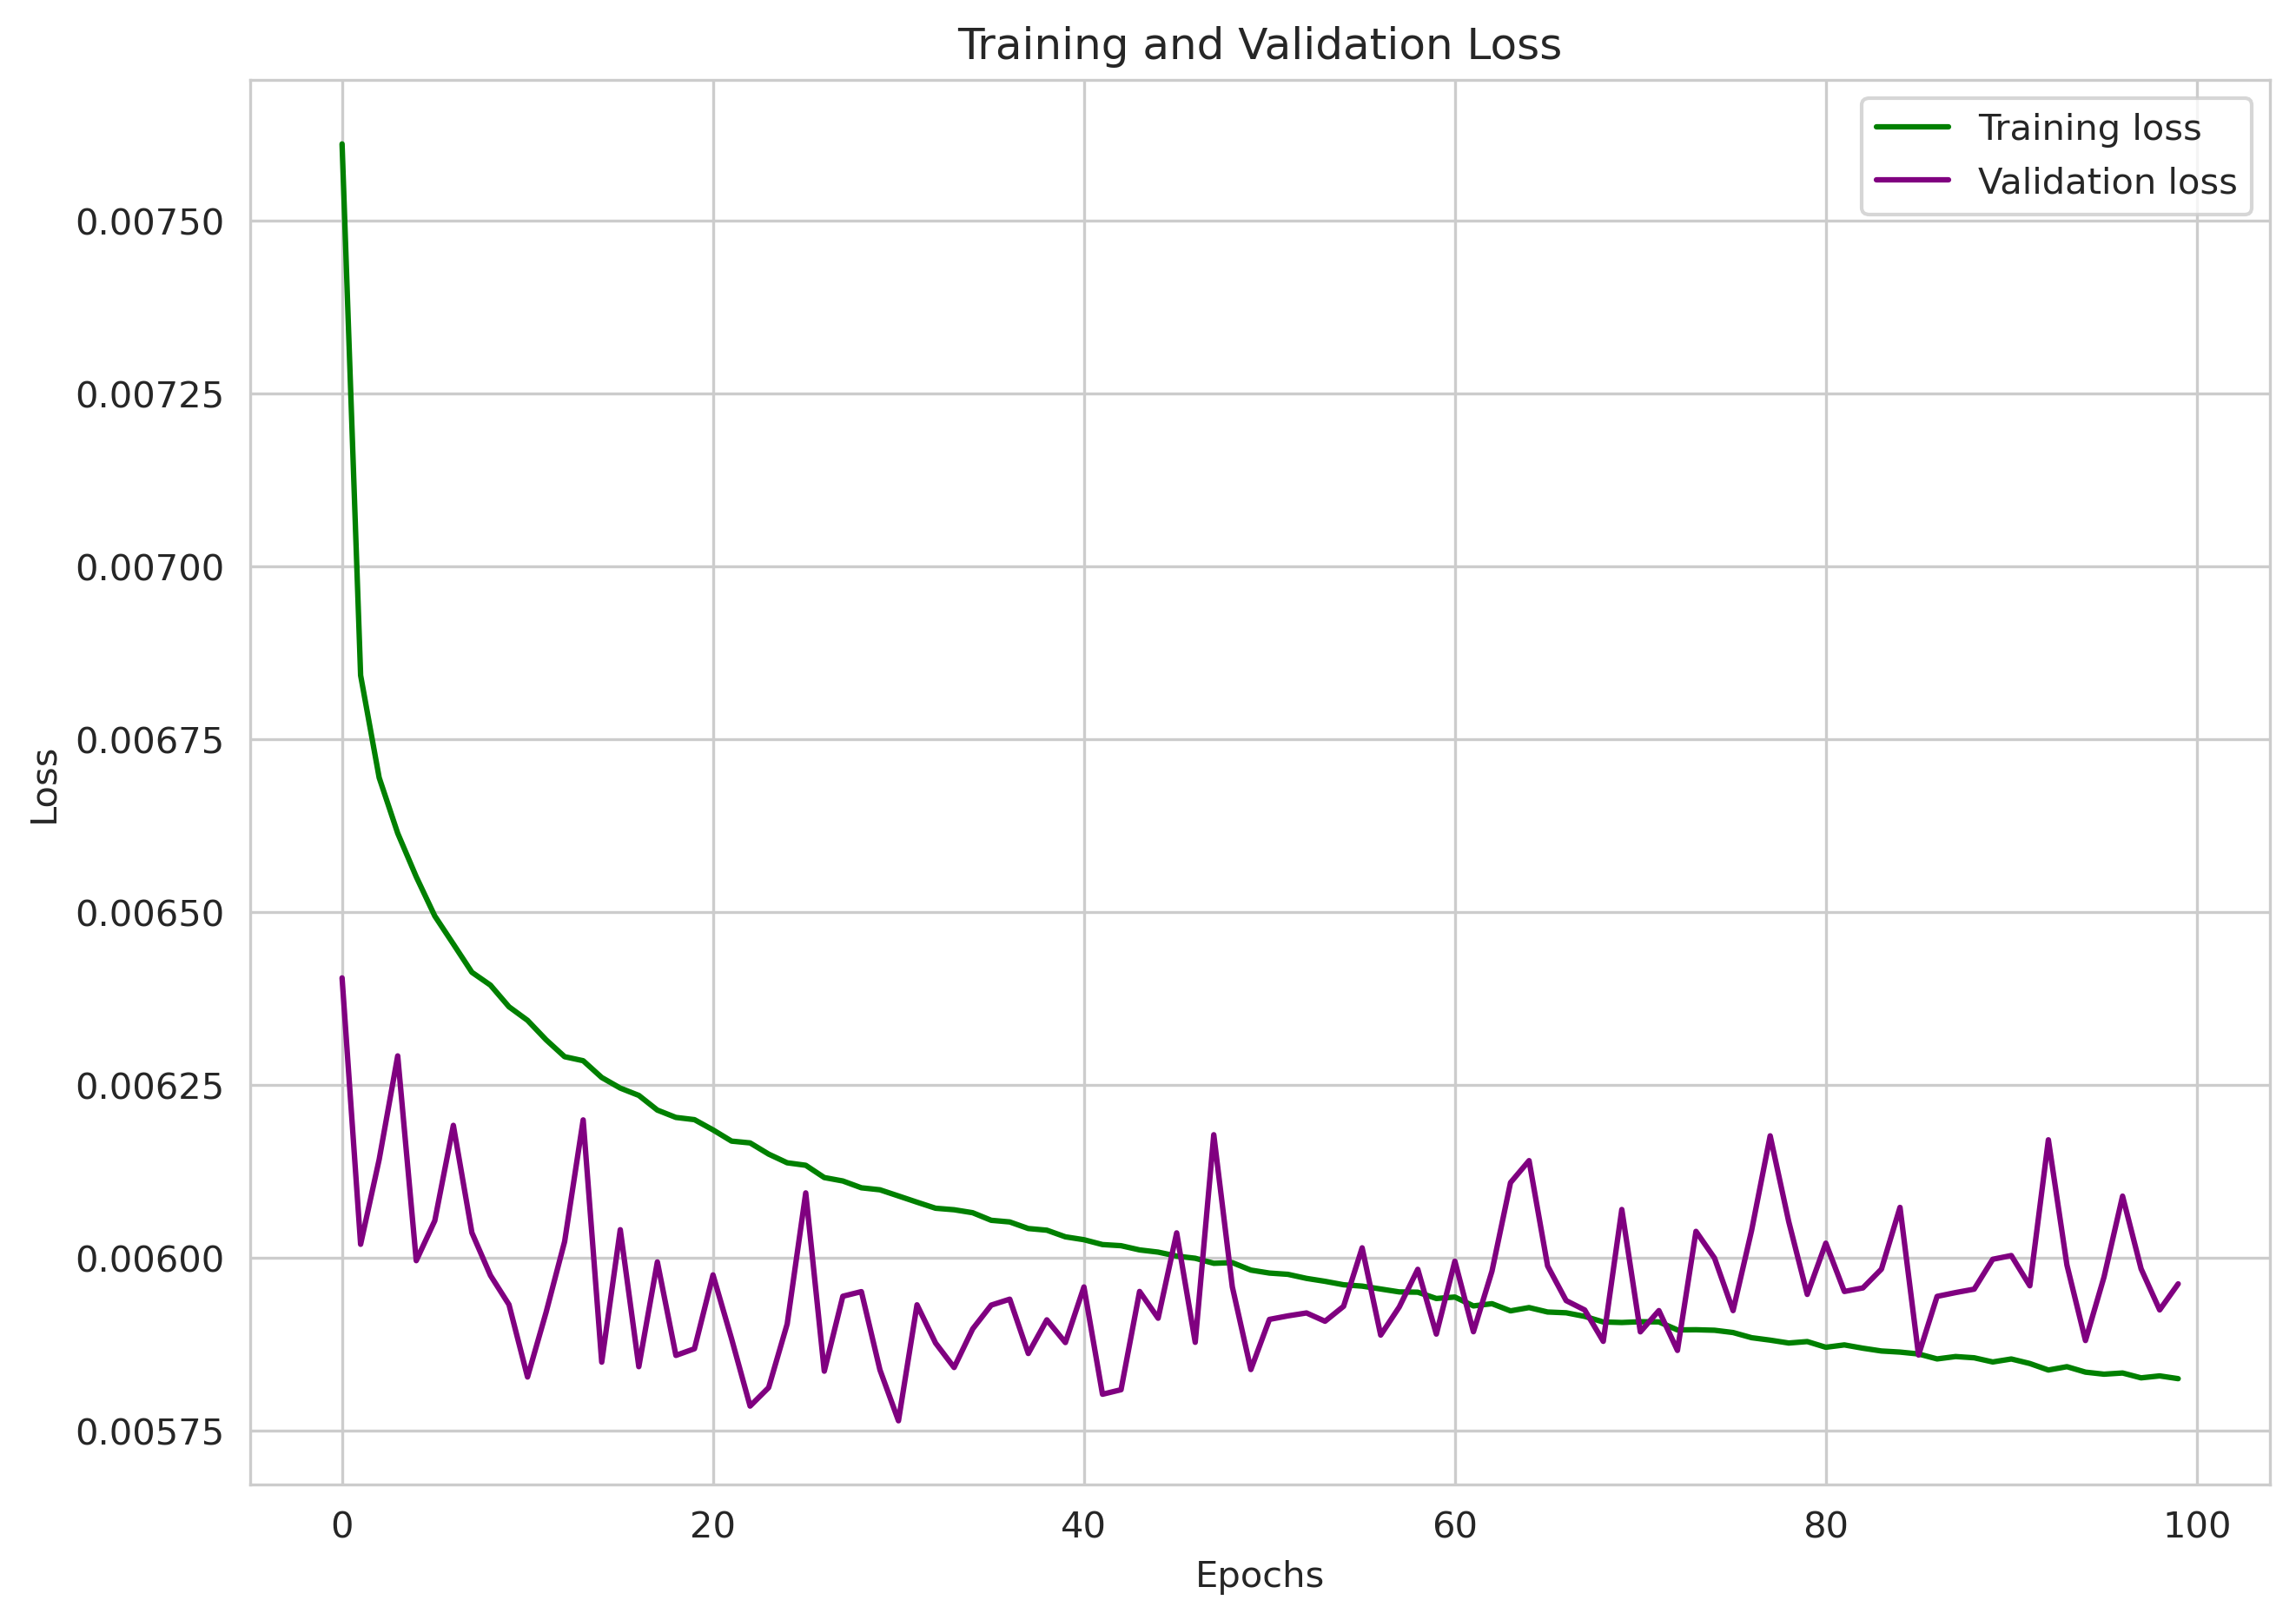

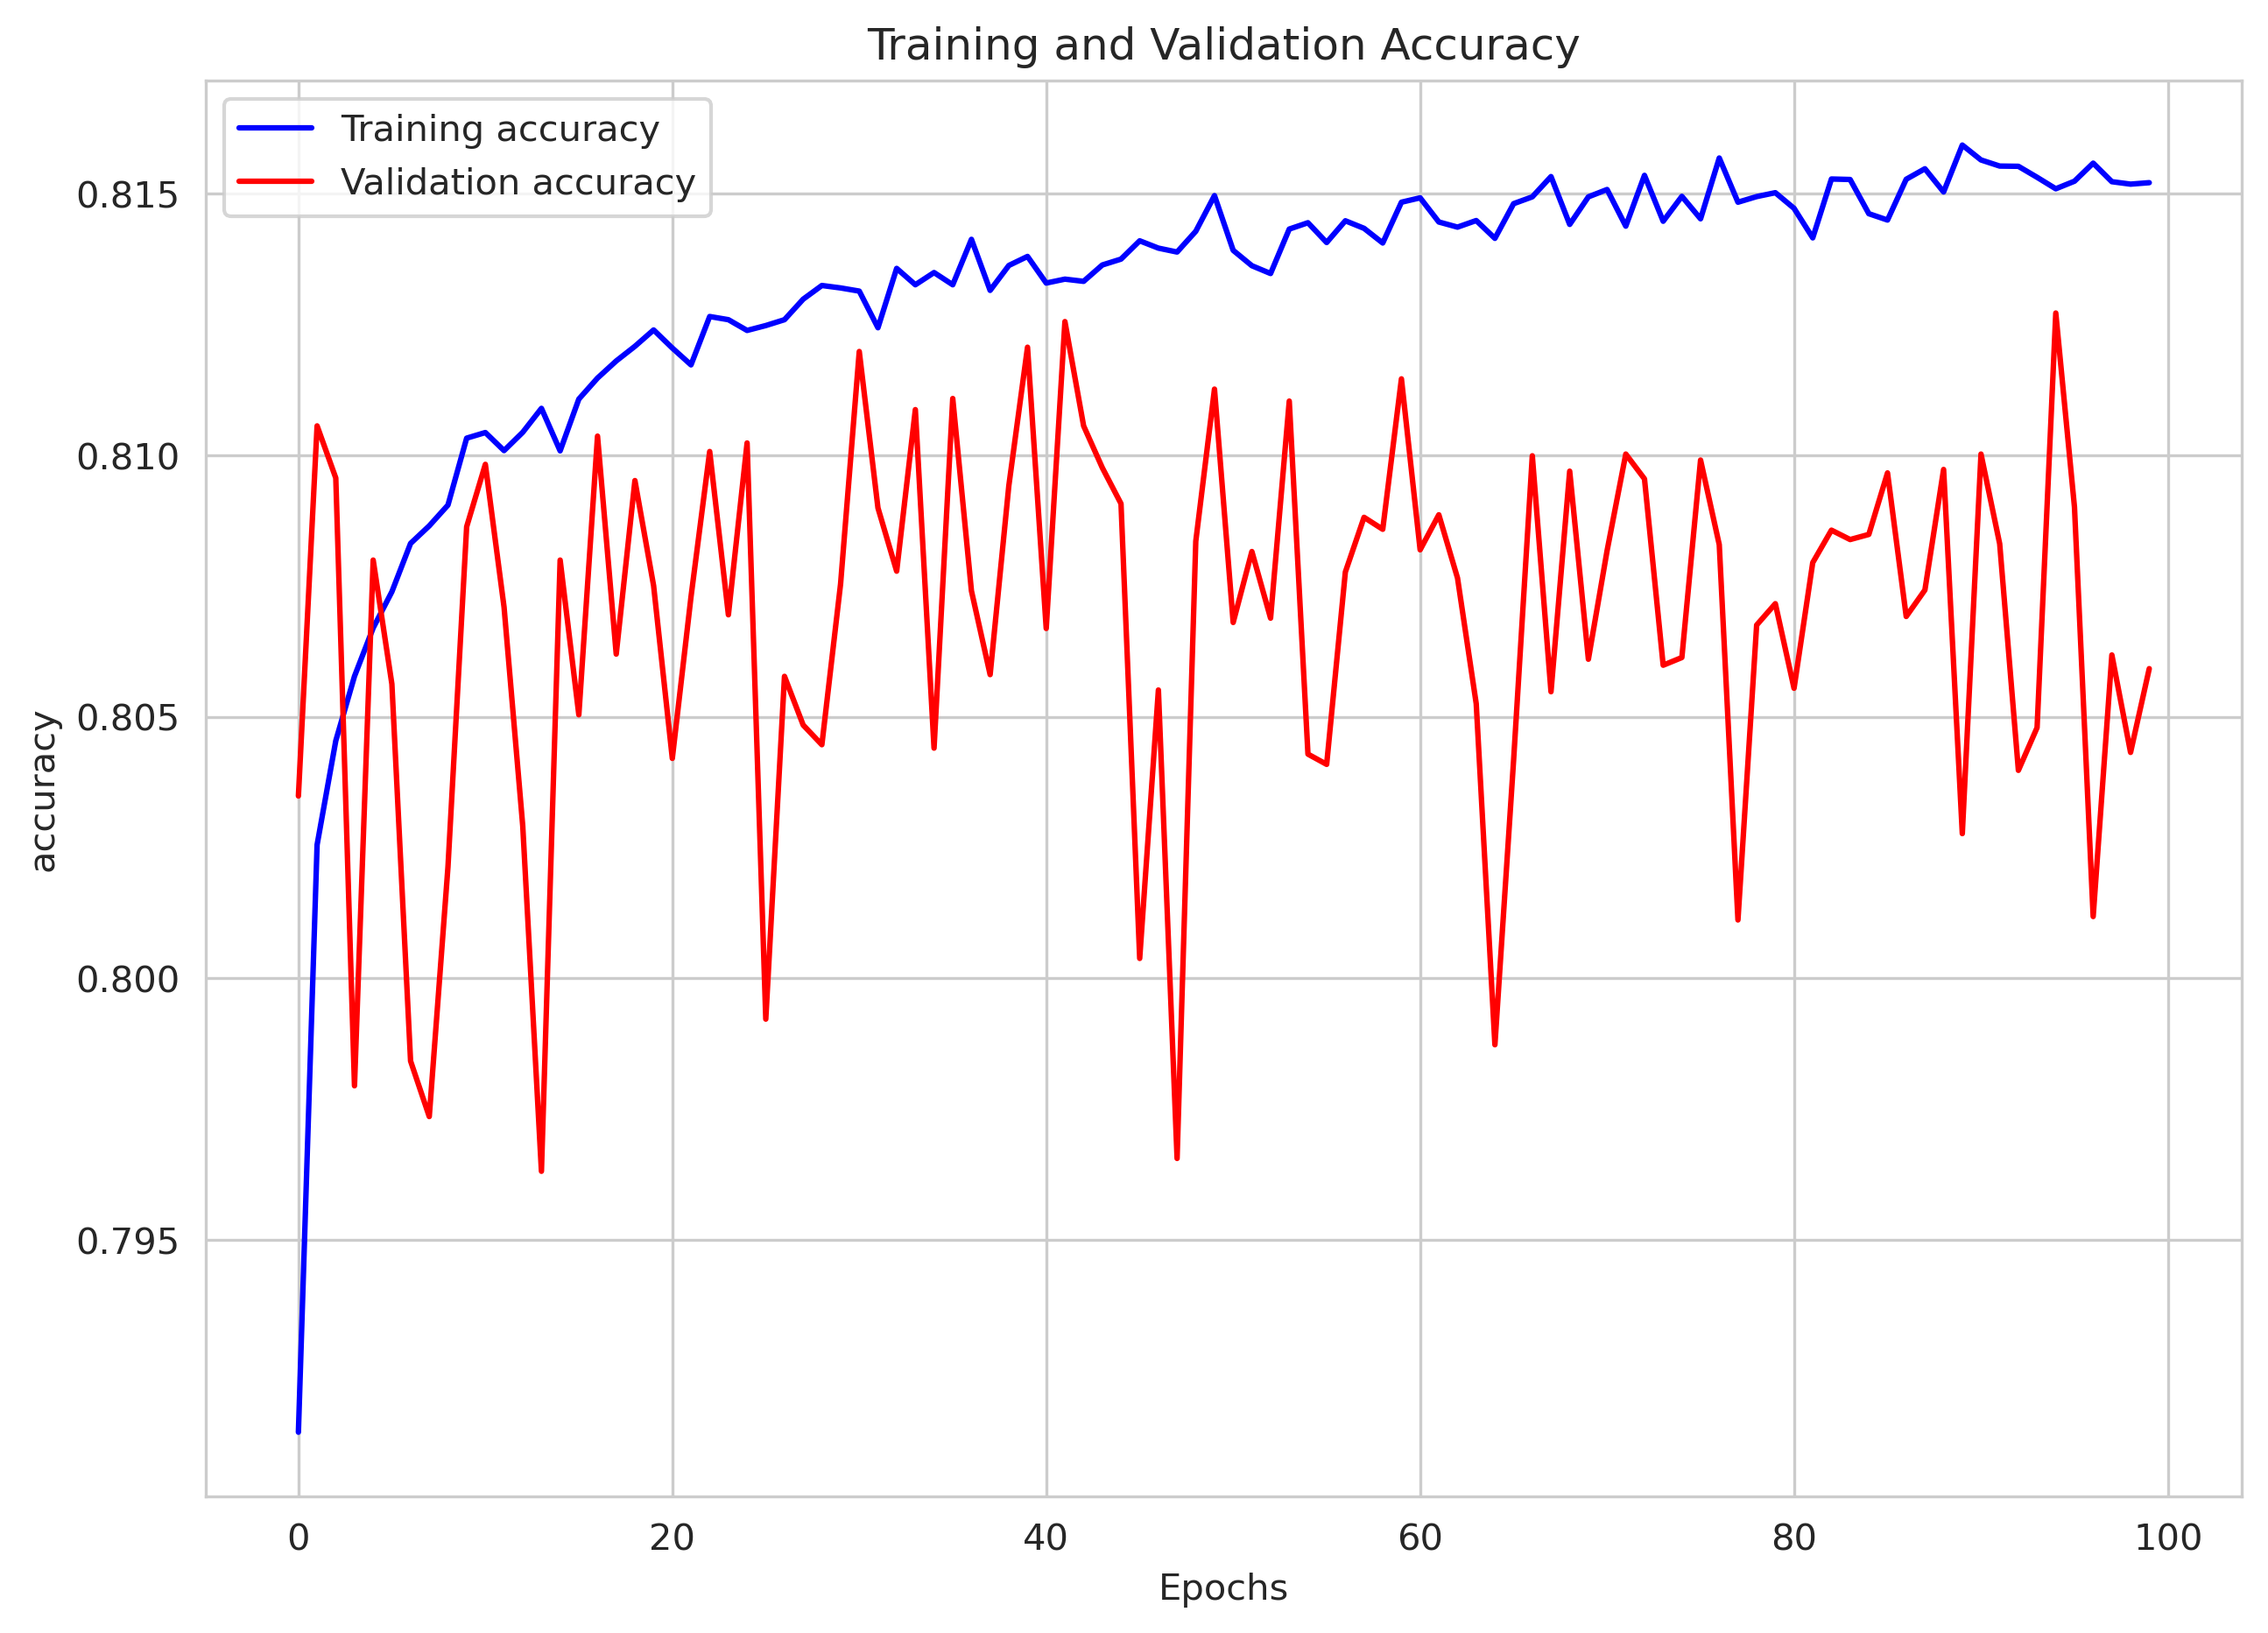

In [17]:
# 定义模型的输入，包括时间序列的数据和标签
inputs = Input(shape=(timesteps, input_dim))


# 定义LSTM层和多头注意力层
lstm_out = LSTM(128, activation='relu', return_sequences=False)(inputs)

# 定义全连接层和输出层
dense = Dense(units=128, activation='relu')(lstm_out)

output = Dense(units=output_dim, activation='relu')(dense)

# 定义模型并进行编译
lstm = Model(inputs=inputs,  outputs=output)


lstm.compile(loss='mse', optimizer=keras.optimizers.Adam(
    learning_rate=learning_rate), metrics=['accuracy'])

# plot_model(model, to_file="Bi-LSTM-MultiheadAtt.png",
#            dpi=300, show_shapes=True)

path_checkpoint = "model_checkpoint_MultiAttLSTM_aqiPre.h5"
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0,
    patience=10
)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=0,
    save_weights_only=True,
    save_best_only=True,
)

# fit network
history = lstm.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(valid_X, valid_y),
#                     callbacks=[es_callback, modelckpt_callback]
                    )
visualize_loss(history, "Training and Validation Loss")
visualize_acc(history, "Training and Validation Accuracy")

# evaluate(model)

# Bi-LSTM-MultiheadAtt

Epoch 1/100
6693/6693 [==============================] - 76s 10ms/step - loss: 0.0078 - accuracy: 0.7858 - val_loss: 0.0067 - val_accuracy: 0.7783
Epoch 2/100
6693/6693 [==============================] - 82s 12ms/step - loss: 0.0070 - accuracy: 0.7976 - val_loss: 0.0063 - val_accuracy: 0.7971
Epoch 3/100
6693/6693 [==============================] - 72s 11ms/step - loss: 0.0069 - accuracy: 0.8005 - val_loss: 0.0062 - val_accuracy: 0.8022
Epoch 4/100
6693/6693 [==============================] - 79s 12ms/step - loss: 0.0068 - accuracy: 0.8024 - val_loss: 0.0064 - val_accuracy: 0.7959
Epoch 5/100
6693/6693 [==============================] - 68s 10ms/step - loss: 0.0067 - accuracy: 0.8044 - val_loss: 0.0061 - val_accuracy: 0.8052
Epoch 6/100
6693/6693 [==============================] - 79s 12ms/step - loss: 0.0066 - accuracy: 0.8052 - val_loss: 0.0061 - val_accuracy: 0.8019
Epoch 7/100
6693/6693 [==============================] - 69s 10ms/step - loss: 0.0066 - accuracy: 0.8060 - val_loss: 0

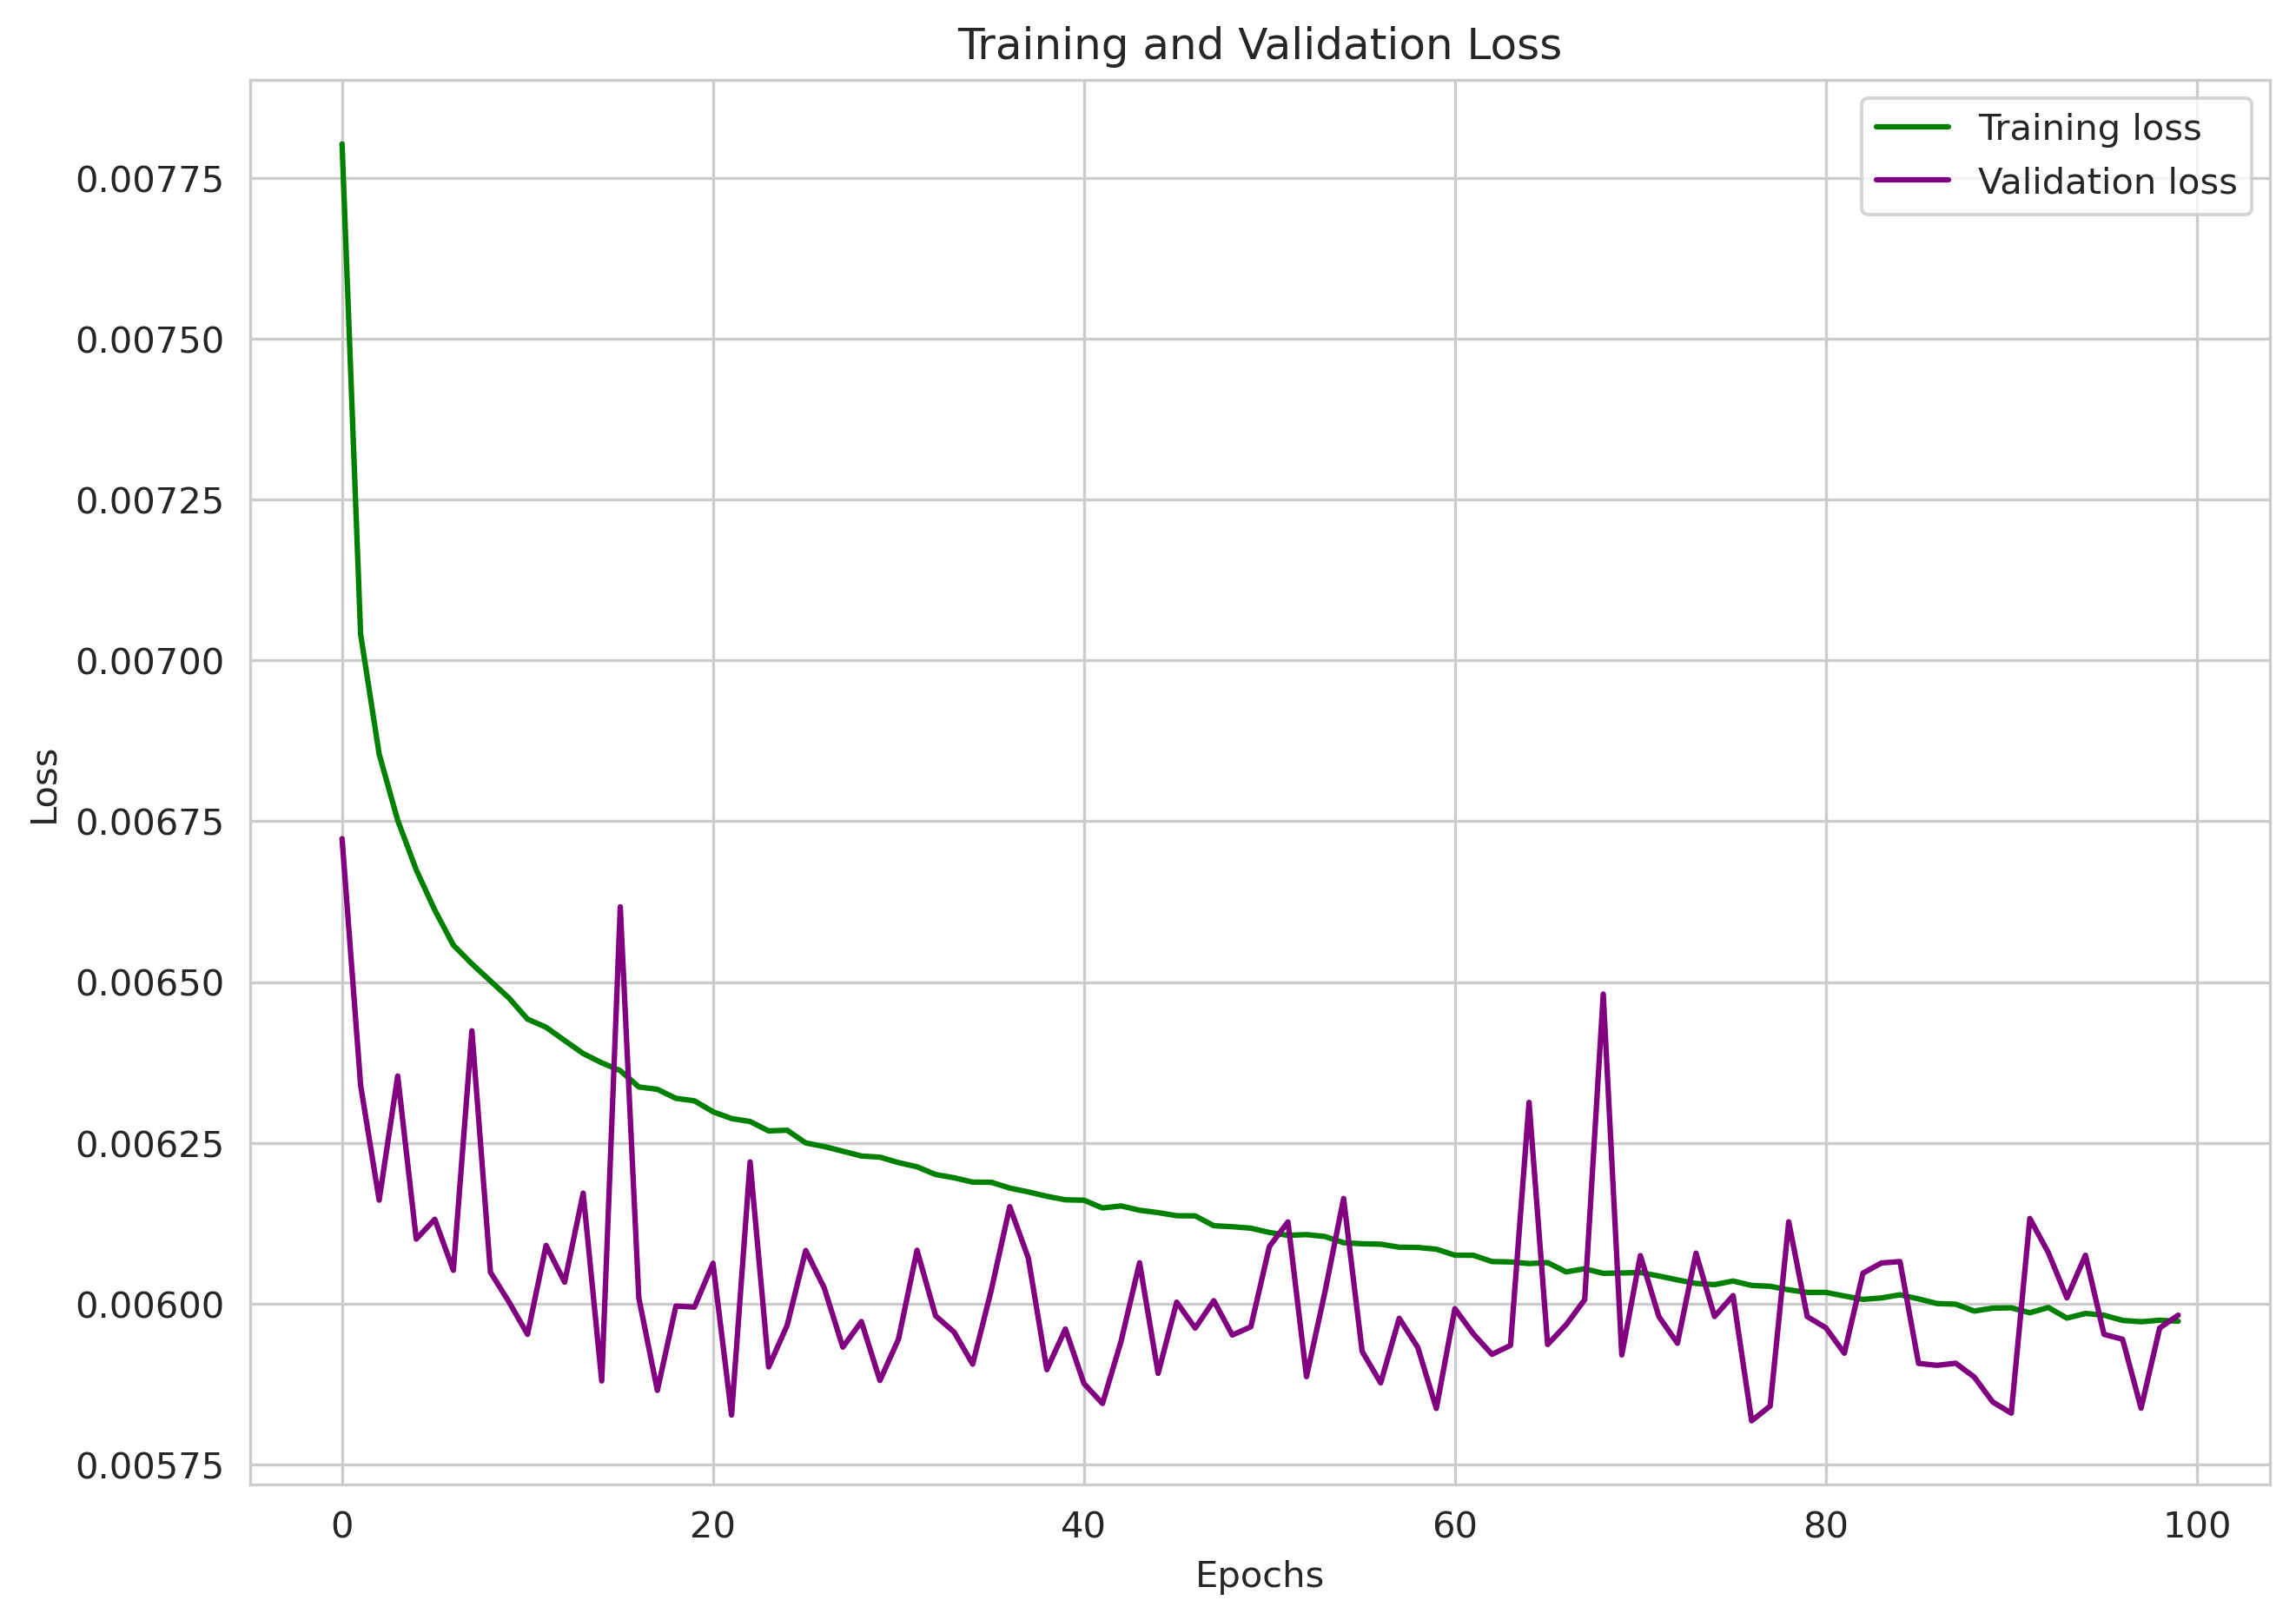

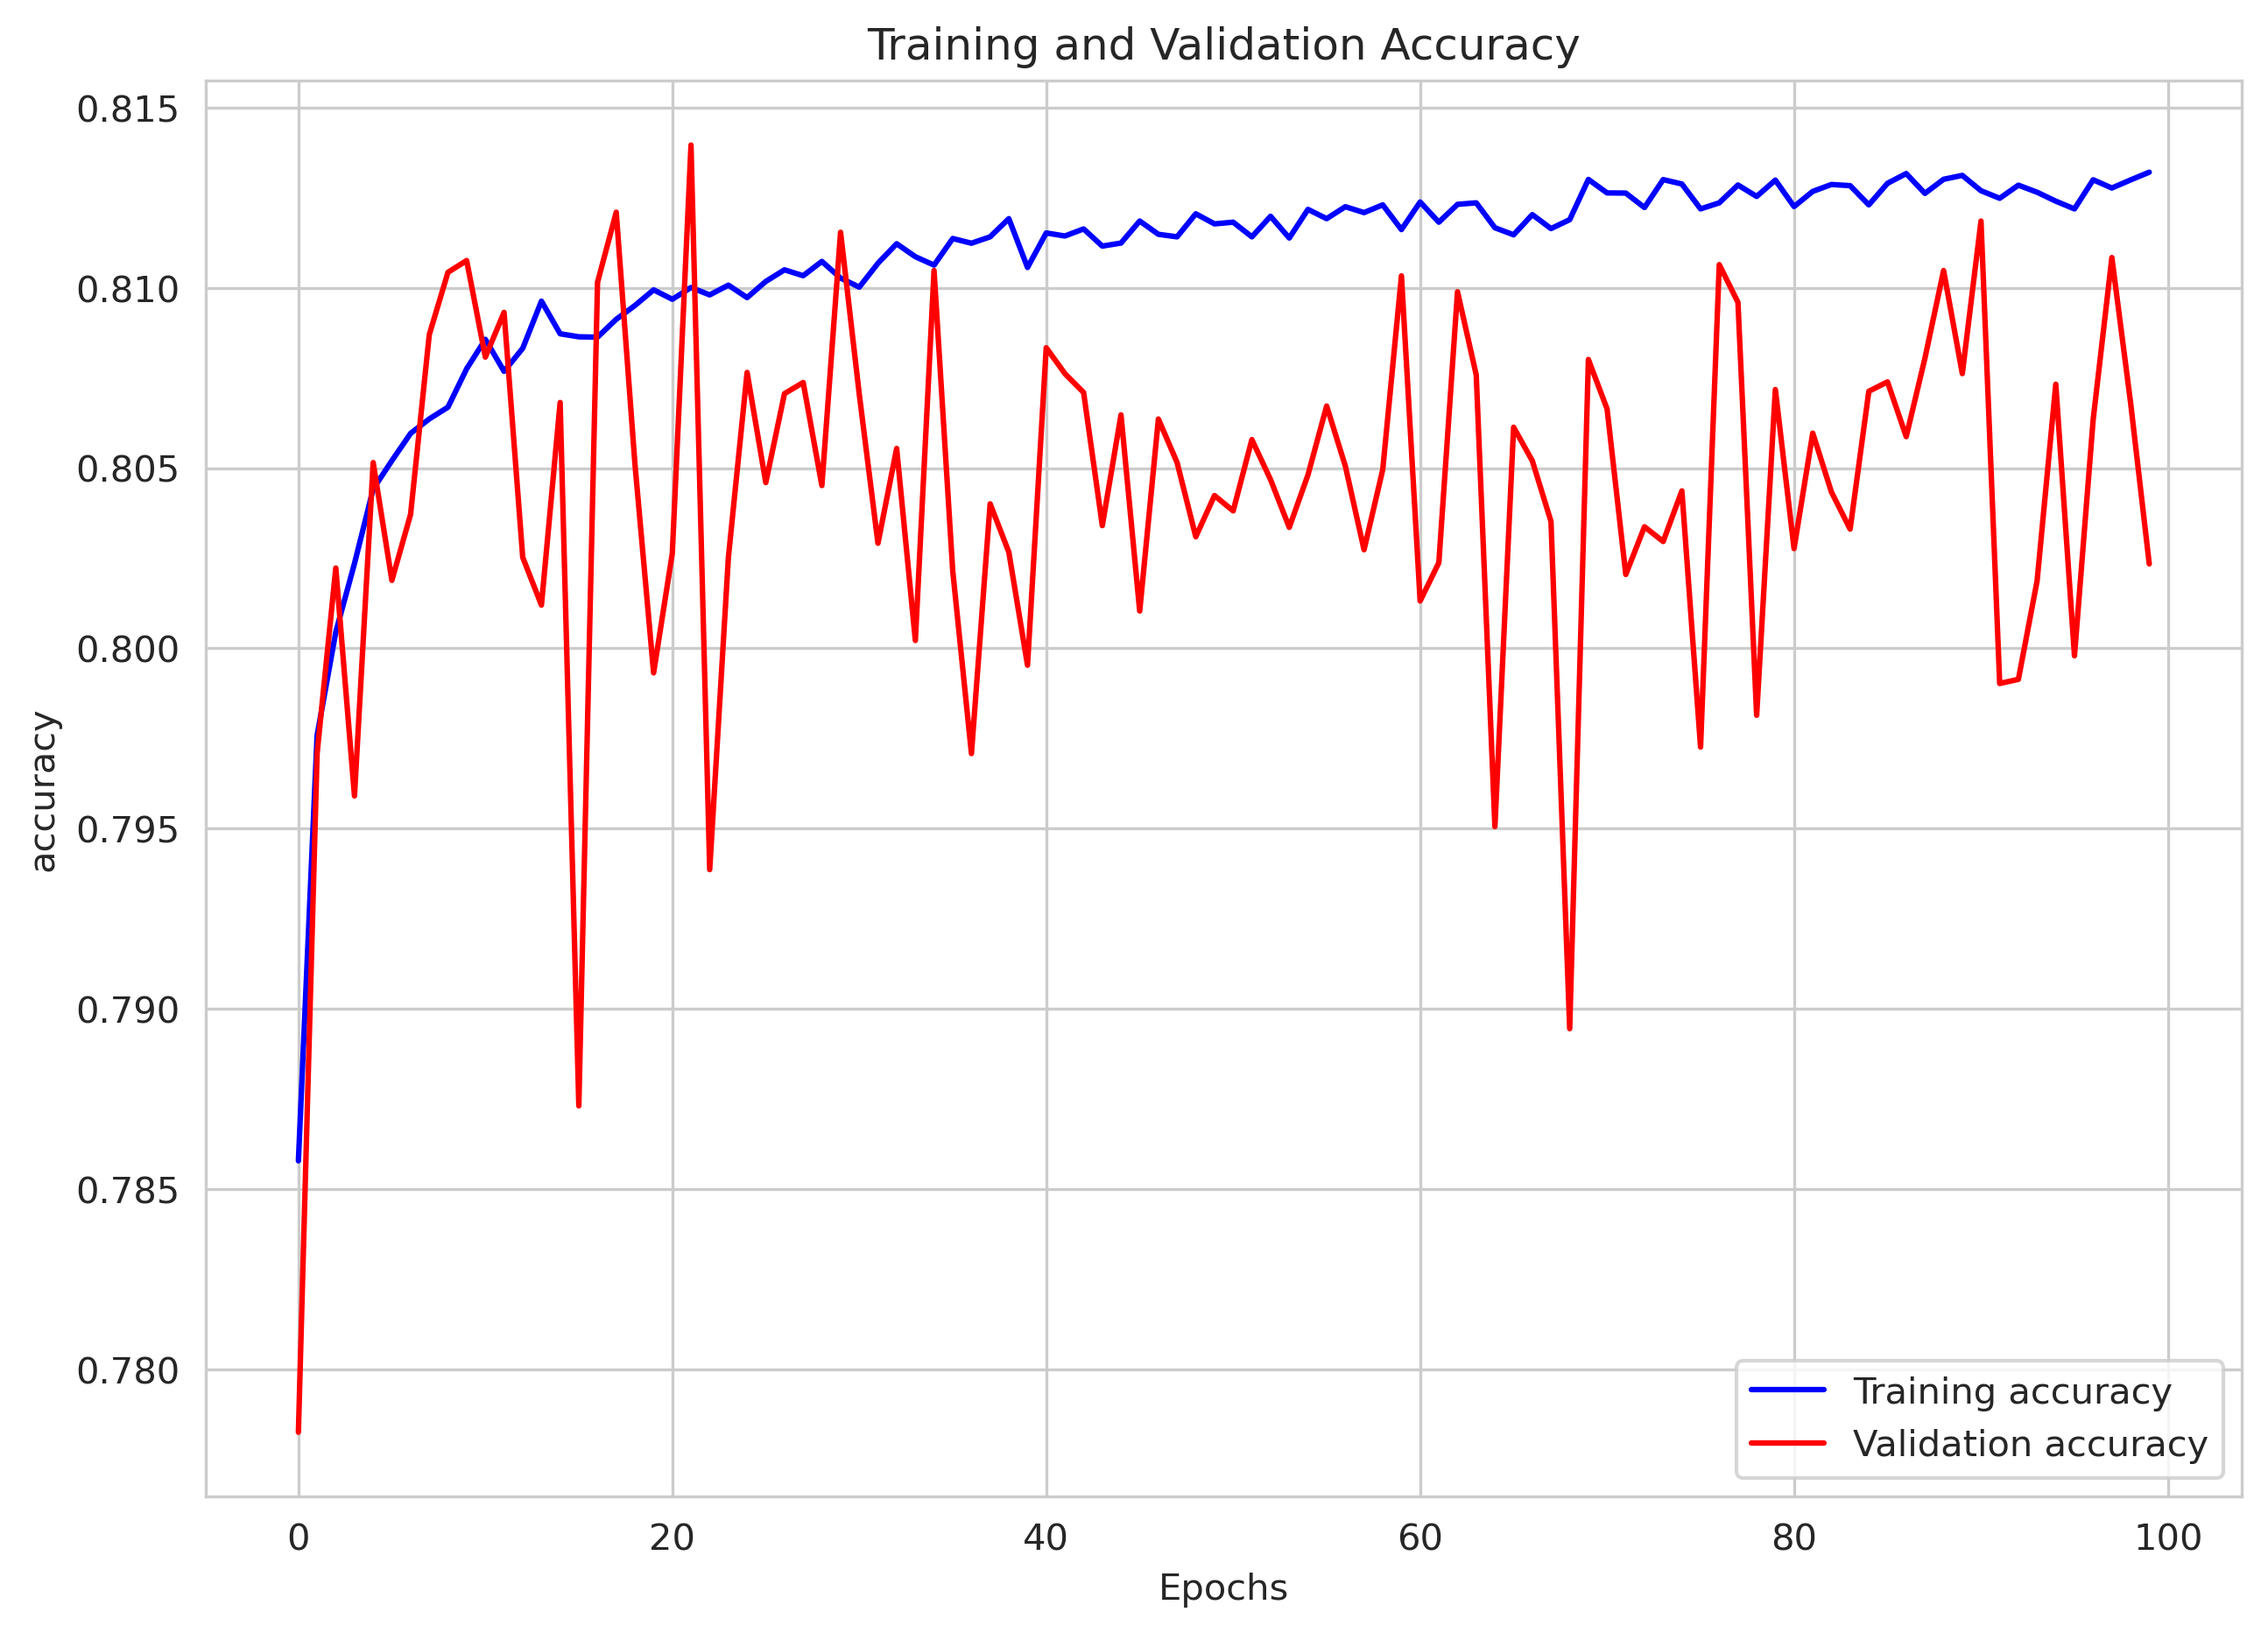

In [18]:
# 定义模型的输入，包括时间序列的数据和标签
inputs = Input(shape=(timesteps, input_dim))


# 定义LSTM层和多头注意力层
lstm_out = Bidirectional(
    LSTM(units=128, activation='relu', return_sequences=True))(inputs)
multihead_attn = MultiHeadAttention(
    num_heads=4, key_dim=32)(lstm_out, lstm_out)

# 定义全连接层和输出层
flatten = Flatten()(multihead_attn)
dense = Dense(units=128, activation='relu')(flatten)

output = Dense(units=output_dim, activation='relu')(dense)

# 定义模型并进行编译
BiLSTMultiheadAtt = Model(inputs=inputs,  outputs=output)


BiLSTMultiheadAtt.compile(loss='mse', optimizer=keras.optimizers.Adam(
    learning_rate=learning_rate), metrics=['accuracy'])

# plot_model(model, to_file="Bi-LSTM-MultiheadAtt.png",
#            dpi=300, show_shapes=True)

path_checkpoint = "model_checkpoint_MultiAttLSTM_aqiPre.h5"
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0,
    patience=10
)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=0,
    save_weights_only=True,
    save_best_only=True,
)

# fit network
history = BiLSTMultiheadAtt.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(valid_X, valid_y),
#                     callbacks=[es_callback, modelckpt_callback]
                    )
visualize_loss(history, "Training and Validation Loss")
visualize_acc(history, "Training and Validation Accuracy")

# evaluate(model)

In [19]:
def inv_scale(df, y):
    max = df.max()[-11:-5]
    min = df.min()[-11:-5]
#     df*(max-min)+min
    yy=y.copy()
    for i in range(len(yy)):
        yy[i] = yy[i]*(max-min)+min  # 25	15	3	7	4	25
    return yy


models = ["RNN", "GRU", "LSTM", "Bi-LSTM-MultiheadAtt"]

def transdata(model,i):
    yhat=model.predict(test_X)
    inv_yhat=inv_scale(dataset,yhat)
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    mae = mean_absolute_error(inv_y, inv_yhat)
    R2=r2_score(inv_y, inv_yhat)
    print('%s Test RMSE: %.3f' % (models[i],rmse))
    print('%s Test MAE: %.3f' % (models[i],mae))    
    print('%s Test R2: %.3f' % (models[i],R2)) 
    data = DataFrame(
    inv_yhat[-100:], index=dataset.index[-100:], columns=dataset.columns[-11:-5])
    return data

957/957 [==============================] - 2s 2ms/step
RNN Test RMSE: 102.151
RNN Test MAE: 32.973
RNN Test R2: 0.856
957/957 [==============================] - 2s 2ms/step
GRU Test RMSE: 101.953
GRU Test MAE: 33.876
GRU Test R2: 0.859
957/957 [==============================] - 2s 2ms/step
LSTM Test RMSE: 99.281
LSTM Test MAE: 31.192
LSTM Test R2: 0.864
957/957 [==============================] - 3s 2ms/step
Bi-LSTM-MultiheadAtt Test RMSE: 98.973
Bi-LSTM-MultiheadAtt Test MAE: 31.313
Bi-LSTM-MultiheadAtt Test R2: 0.863


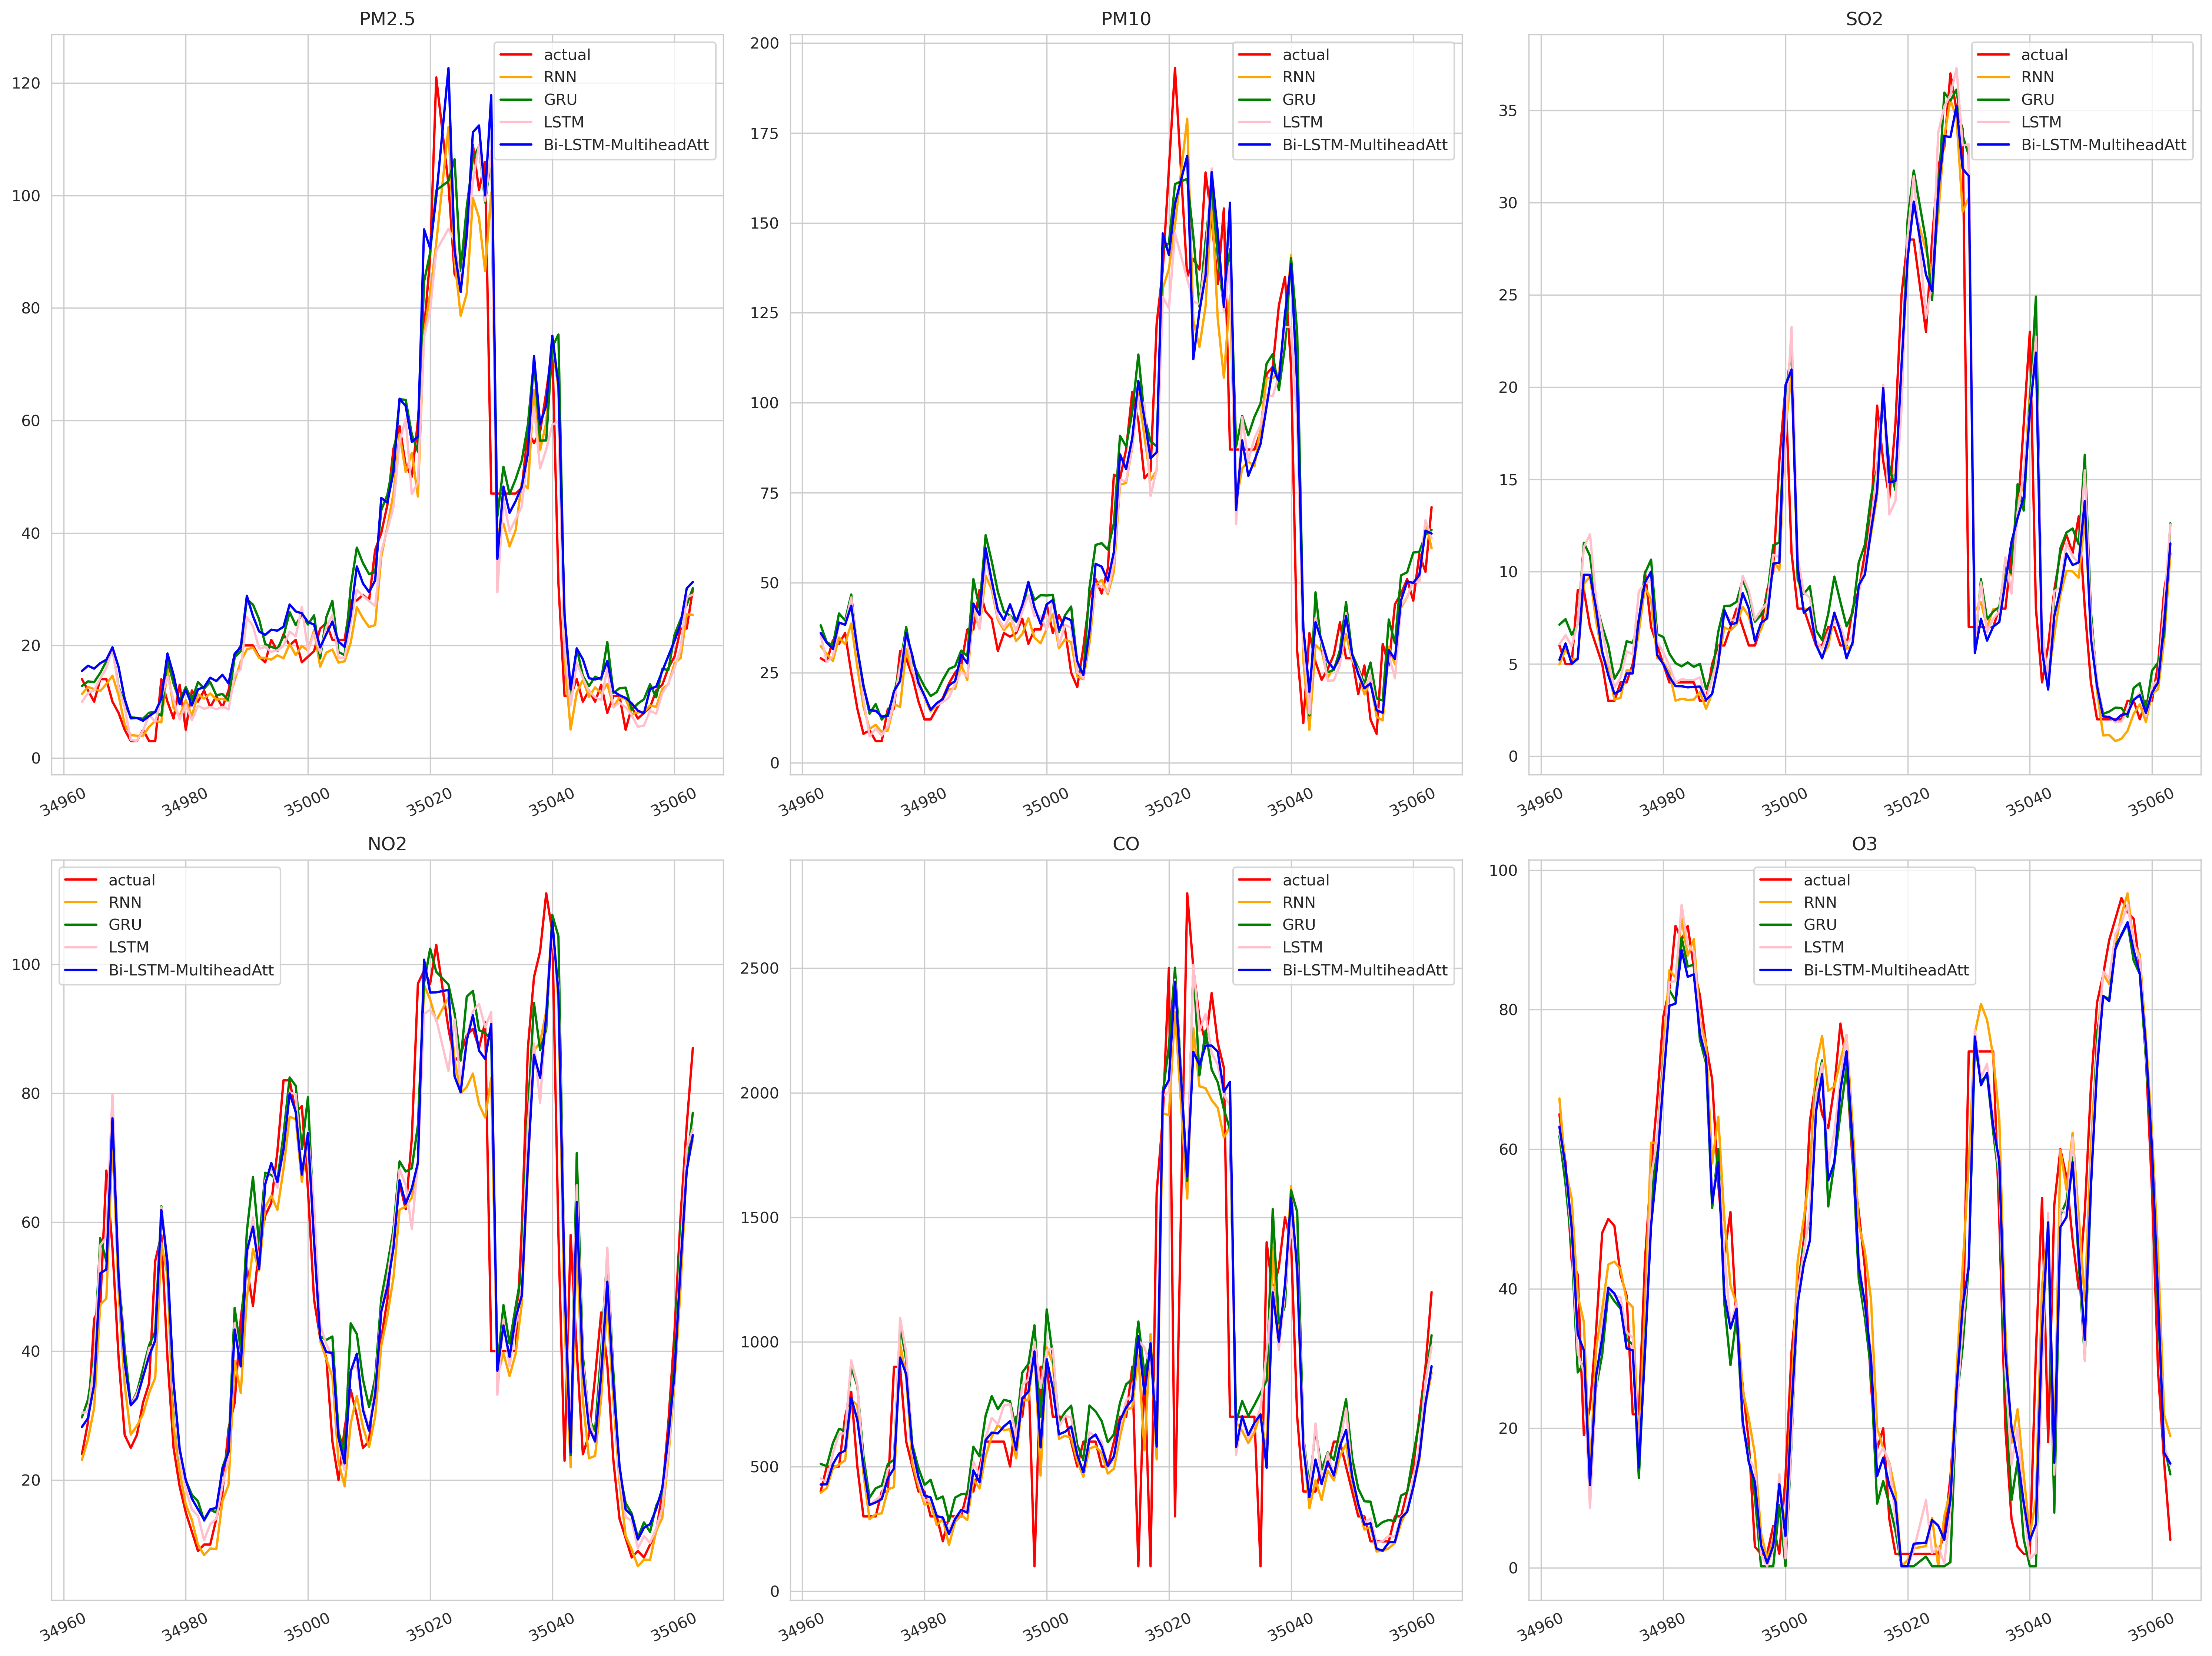

In [20]:
dataset=df_outlier
# 真实数据
inv_y = inv_scale(dataset, test_y)
y = DataFrame(
    inv_y[-100:], index=dataset.index[-100:], columns=dataset.columns[-11:-5])

y1 = transdata(rnn, 0)
y2 = transdata(gru, 1)
y3 = transdata(lstm, 2)
y4 = transdata(BiLSTMultiheadAtt, 3)

fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(20, 15), dpi=300, facecolor="w", edgecolor="k"
)
for i in range(len(feature_keys)-5):
    key = feature_keys[i]
    ax = y[key].plot(
        ax=axes[i // 3, i % 3],
        color='red',
        title="{}".format(titles[i]),
        rot=25,
        label="actual"
    )
    ax = y1[key].plot(
        ax=axes[i // 3, i % 3],
        color='orange',
        rot=25,
        label='RNN'
    )
    ax = y2[key].plot(
        ax=axes[i // 3, i % 3],
        color='green',
        rot=25,
        label='GRU'
    )
    ax = y3[key].plot(
        ax=axes[i // 3, i % 3],
        color='pink',
        rot=25,
        label='LSTM'
    )
    ax = y4[key].plot(
        ax=axes[i // 3, i % 3],
        color='blue',
        rot=25,
        label='Bi-LSTM-MultiheadAtt'
    )
    ax.legend()
plt.tight_layout()